# 07. Model Deployment

## Step by step

In [41]:
import streamlit as st
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from category_encoders import TargetEncoder
import bz2
import _pickle as cPickle
import shap

In [2]:
compressed_model = bz2.BZ2File("RF_price_predicting_model.pkl.pbz2", 'rb')
model = cPickle.load(compressed_model)

In [3]:
st.write("""
# VhehiCALC
This app predicts **Used Cars Values**!
""")
st.write('---')

2022-01-04 19:23:23.546 
  command:

    streamlit run /opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/ipykernel_launcher.py [ARGUMENTS]


In [4]:
# Loads the Used Cars Dataset
cars_final = pd.read_csv('/users/alfon/Desktop/Master/TFM/CSV/03.cars_final_def.csv')
cars_final = cars_final.drop(['Version', 'ZIP'], axis=1)
cars_final['Province'] = cars_final['Province'].fillna("Other")
X= cars_final[cars_final.columns[:-1]]
y= cars_final[cars_final.columns[-1]]

In [5]:
# Sidebar
# Header of Specify Input Parameters
st.sidebar.header('Specify Input Parameters')

DeltaGenerator(_root_container=1, _provided_cursor=None, _parent=DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None), _block_type=None, _form_data=None)

In [6]:
def user_input_features():
    
    
    BRAND = st.sidebar.selectbox('Brand', np.sort(cars_final.Brand.unique()), index = 8)
    MODEL = st.sidebar.selectbox('Model', np.sort(cars_final[cars_final.Brand == BRAND].Model.unique()), index=0)
        
    YEAR = st.sidebar.slider('Year', int(X.Year.min()), int(X.Year.max()), 2021)
    KMS = st.sidebar.number_input('Kms', 0, 1000000, 0, step = 1)
    HP = st.sidebar.slider('Power(Hp)', 0, 1000, 0)
    TRANSMISSION = st.sidebar.selectbox('Transmission', X.Gear_type.unique())
    FUEL = st.sidebar.selectbox('Fuel type', cars_final.Fuel_type.unique(), index=0)
    
    
    CONS = st.sidebar.slider('Fuel cons', int(X.Fuel_cons.min()), int(X.Fuel_cons.max()), int(X.Fuel_cons.mean()))
    DOORS = st.sidebar.slider('Doors', int(X.Doors.min()), int(X.Doors.max()), 5)
    COLOUR = st.sidebar.selectbox('Colour', np.sort(cars_final.Colour.unique()), index=12)
    TYPE = st.sidebar.selectbox('Type', cars_final.Type.unique(), index=0)
    
    
    
    PROVINCE = st.sidebar.selectbox('Province', np.sort(cars_final.Province.unique()), index=29)
    SELLER = st.sidebar.radio("Seller", ("Dealer", "Private"))
     
    
    data = {'Brand': BRAND,
            'Model': MODEL,
            'Type': TYPE,
            'Year': YEAR,
            'Kms': KMS,
            'Hp': HP,
            'Gear_type': TRANSMISSION,
            'Fuel_type': FUEL,
            'Fuel_cons': CONS,
            'Doors': DOORS,
            'Colour': COLOUR,
            'Province': PROVINCE,
            'Seller': SELLER}
    
    features = pd.DataFrame(data, index=[0])
    return features

df_frontend = user_input_features()


In [7]:
# Main Panel

# Print specified input parameters
st.header('Specified Input parameters')
st.write(df_frontend)
st.write('---')

In [8]:
# Build Regression Model

In [9]:
df_frontend.head()

,Brand,Model,Type,Year,Kms,Hp,Gear_type,Fuel_type,Fuel_cons,Doors,Colour,Province,Seller
0,BMW,1 Series,small,2021,0,0,Manual,Diesel,6,5,White,Madrid,Dealer


In [10]:
cars_final.sample(1)

,Brand,Model,Type,Year,Kms,Hp,Gear_type,Fuel_type,Fuel_cons,Doors,Colour,Province,Seller,Price_EUR
24049,Citroen,C4,minivan,2014,151882,116,Manual,Diesel,4.0,5,Red,Pontevedra,Dealer,8500


In [11]:
df = pd.concat([df_frontend, cars_final], axis=0).reset_index().drop('index', axis=1)

In [12]:
for col in ['Brand','Gear_type', 'Fuel_type','Type','Seller']:
    df[col] = df[col].astype('category')

In [13]:
df = pd.get_dummies(data=df,columns=['Gear_type','Fuel_type','Type','Seller'])

In [14]:
encoder = TargetEncoder()

In [15]:
cols_to_encode = ['Brand','Model', 'Colour', 'Province']
cols_encoded = list(map(lambda c: c + '_encoded', cols_to_encode))

df[cols_encoded] = encoder.fit_transform(df[cols_to_encode], df.Price_EUR)

In [16]:
df.drop(['Brand','Model', 'Colour', 'Province', 'Price_EUR'], axis = 1, inplace = True)



In [17]:
df_pred = df[:1]

In [18]:
df_pred

,Year,Kms,Hp,Fuel_cons,Doors,Gear_type_Automatic,Gear_type_Manual,Fuel_type_CNG,Fuel_type_Diesel,Fuel_type_Electric,...,Type_sedan,Type_small,Type_suv,Type_van,Seller_Dealer,Seller_Private,Brand_encoded,Model_encoded,Colour_encoded,Province_encoded
0,2021,0,0,6.0,5,0,1,0,1,0,...,0,1,0,0,1,0,26230.80923,15653.143885,22535.097496,35799.784484


In [19]:
# Apply Model to Make Prediction

prediction = pd.DataFrame(model.predict(df_pred))
prediction.columns = ['Price_EUR']
prediction




,Price_EUR
0,20601.418666


In [20]:
prediction['Price_EUR']= prediction['Price_EUR'].map('€{:,.0f}'.format)


In [21]:
prediction

,Price_EUR
0,"€20,601"


In [22]:
st.header('The predicted value for this cars is:')
st.write(prediction)
st.write('---')

In [23]:
explainer = shap.TreeExplainer(model)

In [38]:
shap_values = explainer.shap_values(df)

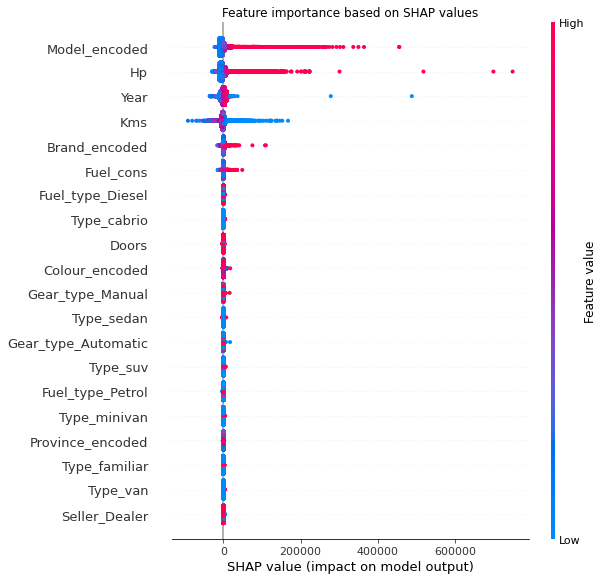

In [70]:
plt.title('Feature importance based on SHAP values')
shap.summary_plot(shap_values, df,show= False)
plt.rcParams['savefig.facecolor']='white'
plt.savefig('/users/alfon/Desktop/Master/TFM/Figs/0.7_Shap_summary_plot.png',bbox_inches = 'tight')


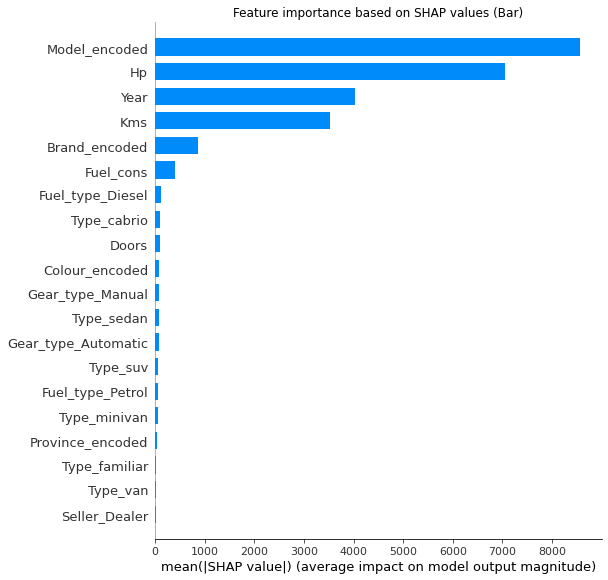

In [71]:
plt.title('Feature importance based on SHAP values (Bar)')
shap.summary_plot(shap_values, df, plot_type="bar", show=False)
plt.rcParams['savefig.facecolor']='white'
plt.savefig('/users/alfon/Desktop/Master/TFM/Figs/0.7_Shap_summary_plot_bar.png',bbox_inches = 'tight')

